In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgunsl.ttf'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)
font_path = 'C:/Windows/Fonts/malgunsl.ttf'

# 폰트 이름 가져오기

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지


In [17]:
from IPython.core.display import HTML

# 글씨 크기를 10px로 조절하는 CSS
css = """
<style>
table.dataframe td, table.dataframe th {
    font-size: 10px;
}
</style>
"""
HTML(css)

In [1]:
import pandas as pd
data = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
data=data.loc[(data['SerlNo'] == 4419)]
data['measDate']=pd.to_datetime(data['measDate'])
data['Time'] = data['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
start_date=data['measDate'][0]
data['Week'] = data['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
result = data.groupby(['Week', 'Time'])['내부CO2'].mean().reset_index()
result['내부CO2'] = result['내부CO2'].round(1)
result



,Week,Time,내부CO2
0,1,Day,442.5
1,1,Night,507.3
2,2,Day,339.8
3,2,Night,400.9
4,3,Day,420.0
5,3,Night,465.8
6,4,Day,401.1
7,4,Night,456.4
8,5,Day,432.8
9,5,Night,485.4


### 생육 정보 얹기

우선 2021년에 토마토를 기른 작기 ID를 불러오자

In [3]:
from src.api import SmartFarmAPI

api = SmartFarmAPI(config="config.yaml")
df = pd.DataFrame(api.crop_season.getCroppingSeasonDataList("2021"))
df_tomato = df[(df["itemName"] == "토마토") & (df["acqAutoYn"] == "Y")]
df_tomato_id=df_tomato['croppingSerlNo'].unique()
df_tomato_id

Service key: 9d7b25ec76b9465da2507e0c97ec6aaa
Snaity check를 위해 스마트팜 보급 농가의 사용자ID, 시설ID, 지역, 품목코드 조회합니다.

        상세 기능 번호  : 1
        상세 기능 설명  : 스마트팜 보급 농가의 사용자ID, 시설ID, 지역, 품목코드 조회   
        
        * 요청 메세지 명세 *
            - `None`
        
        * 응답 메세지 명세 *
            - `userId`      : 사용자 ID
            - `facilityId`  : 시설 ID
            - `addressName` : 지역명 (법정동명)
            - `itemCode`    : 품목코드 (별첨 1. 품목코드 참고: ItemCode.get_code())
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        
Service key가 유효합니다.

        상세 기능 번호  : 1
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기 정보 조회 
        
        * 요청 메세지 명세 *    
            year: 작기 시작 년도 String (형식 : yyyy)
            
        * 응답 메세지 명세 *
            facilityId: 시설 ID String 
            addressName: 지역명 String (법정동명)
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode       : 품목코드 String 
            itemName: 품

array([4419, 4420, 4430, 4431, 4514, 4425, 4504, 4423, 4957, 4549, 4557,
       4577, 4731, 4965, 4827, 4749, 4736, 4724, 4755, 4719, 4967, 5033,
       4922, 4791, 4796, 4828, 4744, 4800, 5041, 4753, 4751, 4730, 4857,
       4951, 4685, 4923, 4978, 4862, 4948, 4771, 4772, 4904, 4915, 4940,
       4908, 4925, 4757, 4941, 4860, 4769, 4809, 4839, 4905, 4919, 4760,
       4937, 4920, 4783, 4955, 4792, 4927, 4737, 4819, 4911, 4777, 4820,
       4817, 4953, 4980, 5038, 4971, 4952, 5035, 4934, 5031, 4732, 4918],
      dtype=int64)

그 중 맨 첫번째인 ID 4419의 생육정보를 가져온다. 

In [367]:
def get_tomato_growth_info(df_sfecific, Serlid):
    df=pd.DataFrame(api.crop_season.getCultivateDataList(Serlid))
    df['examine_feature'] = df['examinIemNm'] + '(' + df['examinIemUnit'] + ')'
    tomato_growth_info=df.drop(['examinIemNm','examinIemUnit'],axis=1)
    tomato_growth_info['examinDe']=pd.to_datetime(tomato_growth_info['examinDe'])
    tomato_growth_info_pivoted = tomato_growth_info.iloc[:].pivot_table(index='examinDe', columns='examine_feature', values='examinIemValue', aggfunc="mean")

    first_examin_week=df_sfecific.loc[df_sfecific['measDate'].dt.date == tomato_growth_info_pivoted.index[0].date()]['Week'].iloc[0]
    tomato_growth_info_pivoted['Week'] = range(first_examin_week, len(tomato_growth_info_pivoted)+first_examin_week)
    tomato_growth_info_pivoted.set_index('Week', append=True, inplace=True)
    return tomato_growth_info_pivoted

tomato_growth_info_pivoted=get_tomato_growth_info(data,df_tomato_id[7])
tomato_growth_info_pivoted


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


AttributeError: Can only use .dt accessor with datetimelike values

In [104]:
raw_tomato = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
raw_tomato['measDate']=pd.to_datetime(raw_tomato['measDate'])
start_date=raw_tomato['measDate'][0]
#주차 계산
raw_tomato['Week'] = raw_tomato['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
raw_tomato

,measDate,SerlNo,내부CO2,이슬점온도,(양액)공급EC,토양EC,(양액)배액EC,외부습도,내부습도,지습,...,강우감지,(양액)총급액,(양액)총배액,일사량,외부온도,내부온도,지온,외부풍향,외부풍속,Week
0,2021-01-12 00:00:00,4419,606.17,NaN,NaN,NaN,NaN,NaN,92.77,NaN,...,NaN,NaN,NaN,NaN,-3.91,15.33,NaN,NaN,NaN,1
1,2021-01-12 00:00:00,4420,664.73,NaN,NaN,NaN,NaN,NaN,83.61,NaN,...,NaN,NaN,NaN,2.00,NaN,13.00,NaN,NaN,0.07,1
2,2021-01-12 01:00:00,4419,NaN,NaN,NaN,NaN,NaN,NaN,95.14,NaN,...,0.0,NaN,NaN,0.00,NaN,15.33,NaN,NaN,0.00,1
3,2021-01-12 01:00:00,4420,680.95,NaN,NaN,NaN,NaN,NaN,84.35,NaN,...,NaN,NaN,NaN,1.95,NaN,10.52,NaN,NaN,0.09,1
4,2021-01-12 02:00:00,4419,645.50,NaN,NaN,NaN,NaN,NaN,94.78,NaN,...,NaN,NaN,NaN,NaN,-5.73,15.33,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336993,2022-12-02 19:00:00,4957,NaN,7.50,NaN,NaN,NaN,NaN,65.80,NaN,...,NaN,NaN,NaN,NaN,NaN,5.15,NaN,135.0,2.00,99
336994,2022-12-02 20:00:00,4957,NaN,7.25,NaN,NaN,NaN,NaN,66.00,NaN,...,NaN,NaN,NaN,NaN,NaN,5.07,NaN,135.0,1.75,99
336995,2022-12-02 21:00:00,4957,NaN,7.25,NaN,NaN,NaN,NaN,65.95,NaN,...,NaN,NaN,NaN,NaN,NaN,5.00,NaN,135.0,2.04,99
336996,2022-12-02 22:00:00,4957,NaN,7.25,NaN,NaN,NaN,NaN,66.46,NaN,...,NaN,NaN,NaN,NaN,NaN,4.92,NaN,135.0,1.00,99


전체 토마토와 작기 ID를 넣으면 주차별 수확 데이터 프레임 출력

In [366]:
def get_tomato_growth_info(df_sfecific, Serlid):
    df_sfecific['measDate'] = pd.to_datetime(df_sfecific['measDate'])

    df=pd.DataFrame(api.crop_season.getCultivateDataList(Serlid))
    df['examine_feature'] = df['examinIemNm'] + '(' + df['examinIemUnit'] + ')'
    tomato_growth_info=df.drop(['examinIemNm','examinIemUnit'],axis=1)
    tomato_growth_info['examinDe']=pd.to_datetime(tomato_growth_info['examinDe'])
    tomato_growth_info_pivoted = tomato_growth_info.iloc[:].pivot_table(index='examinDe', columns='examine_feature', values='examinIemValue', aggfunc="mean")

    first_examin_week=df_sfecific.loc[df_sfecific['measDate'].dt.date == tomato_growth_info_pivoted.index[0].date()]['Week'].iloc[0]

    tomato_growth_info_pivoted['Week'] = range(first_examin_week, len(tomato_growth_info_pivoted)+first_examin_week)
    tomato_growth_info_pivoted.set_index('Week', append=True, inplace=True)
    return tomato_growth_info_pivoted

raw_tomato = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
tomato_growth_info_pivoted=get_tomato_growth_info(raw_tomato,df_tomato_id[7])
tomato_growth_info_pivoted


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


,examine_feature,개화군(점),생장길이(mm),열매수(개),엽수(개),엽장(mm),엽폭(mm),줄기직경(mm),착과군(점),최종화방차수(차),화방높이(mm)
examinDe,Week,,,,,,,,,,
2021-03-03,8,0.0000,0.00,0.00,5.10,173.25,123.75,4.4675,0.0000,0.00,0.00
2021-03-10,9,0.2200,69.50,0.50,8.25,182.75,129.25,5.0500,0.0450,1.00,22.50
2021-03-17,10,0.1950,75.25,2.25,8.00,255.25,185.00,7.3000,0.2125,1.00,98.75
2021-03-24,11,0.4500,97.50,4.25,10.50,275.00,186.00,7.1500,0.3800,2.00,96.00
2021-03-30,12,0.7375,69.50,6.00,12.75,275.25,181.75,7.3225,0.5350,2.75,62.75
2021-04-07,13,0.7600,125.75,13.00,15.75,270.25,173.25,6.0600,1.0825,3.75,52.50
2021-04-14,14,0.9625,54.25,20.00,13.50,183.75,125.00,4.5250,1.3900,4.50,21.50
2021-04-21,15,0.7600,28.75,33.00,15.00,314.50,210.75,7.0650,2.6350,6.00,64.50
2021-04-28,16,0.6000,101.50,45.25,18.25,220.75,140.00,5.3350,3.4075,6.25,44.50


작기 ID와, 궁금한 feature를 넣으면 주차별 낮, 밤 feature의 평균값 출력하는 함수

In [339]:
import pandas as pd

def get_mean_by_week(df, SerlNo, feature):
    df = df.loc[df['SerlNo'] == SerlNo]
    df['measDate'] = pd.to_datetime(df['measDate'])
    start_date = df['measDate'].min()  # 시작 날짜를 데이터셋 내 최소 날짜로 설정
    df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
    df['Time'] = df['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
    result = df.groupby(['Week', 'Time'])[feature].mean().reset_index()
    result[feature] = result[feature].round(1)  # 결과 컬럼 이름을 동적으로 처리
    return result


data = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
get_mean_by_week(data, 4419, '내부CO2')


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Week,Time,내부CO2
0,1,Day,442.5
1,1,Night,507.3
2,2,Day,339.8
3,2,Night,400.9
4,3,Day,420.0
5,3,Night,465.8
6,4,Day,401.1
7,4,Night,456.4
8,5,Day,432.8
9,5,Night,485.4


작물의 수확 데이터랑 환경 데이터를 동시에 Plot해주는 함수


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

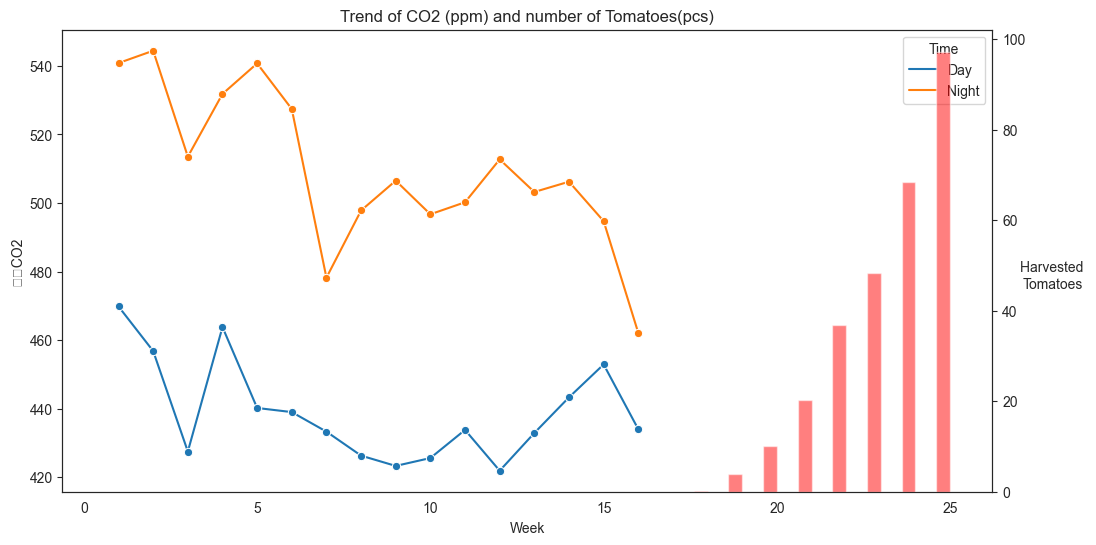

In [365]:

import matplotlib.pyplot as plt
import seaborn as sns

# 예시: tomato_growth_info_pivoted 데이터프레임에 누락된 주차 데이터 추가
def draw_graph_harvest_and_circumstance(Serlid, fruit_feature, circum_feature):
    tomato_growth_info_pivoted=get_tomato_growth_info(raw_tomato,Serlid)
    tomato_growth_info_pivoted.reset_index(inplace=True)
    tomato_growth_info_pivoted=tomato_growth_info_pivoted[['Week', fruit_feature]]

    circumstance_trend=get_mean_by_week(raw_tomato, Serlid, circum_feature)
    max_week = max(circumstance_trend['Week'].max(), tomato_growth_info_pivoted['Week'].max())

    for week in range(1, max_week + 1):
        if week not in tomato_growth_info_pivoted['Week'].values:
            # 누락된 주차의 행을 DataFrame으로 만듦
            missing_week_df = pd.DataFrame({'Week': [week], '열매수(개)': [0]})
            # pd.concat()을 사용해 기존 DataFrame에 추가
            tomato_growth_info_pivoted = pd.concat([tomato_growth_info_pivoted, missing_week_df], ignore_index=True)

    tomato_growth_info_pivoted = tomato_growth_info_pivoted.sort_values(by='Week').reset_index(drop=True)

    # 그래프 그리기
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(data=circumstance_trend, x="Week", y="내부CO2", hue="Time", marker="o")
    ax2 = ax.twinx()
    ax2.bar(tomato_growth_info_pivoted['Week'] - 0.2, tomato_growth_info_pivoted['열매수(개)'], width=0.4, alpha=0.5, color='red')
    ax2.set_ylabel('Harvested \nTomatoes', rotation=0, labelpad=20)
    plt.title('Trend of CO2 (ppm) and number of Tomatoes(pcs)')
    plt.show()

draw_graph_harvest_and_circumstance(df_tomato_id[9], '열매수(개)', '내부CO2')



        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T


        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measDate'] = pd.to_datetime(df['measDate'])
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Week'] = df['measDate'].apply(lambda x: ((x - start_date).days // 7) + 1)
C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\1583482529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

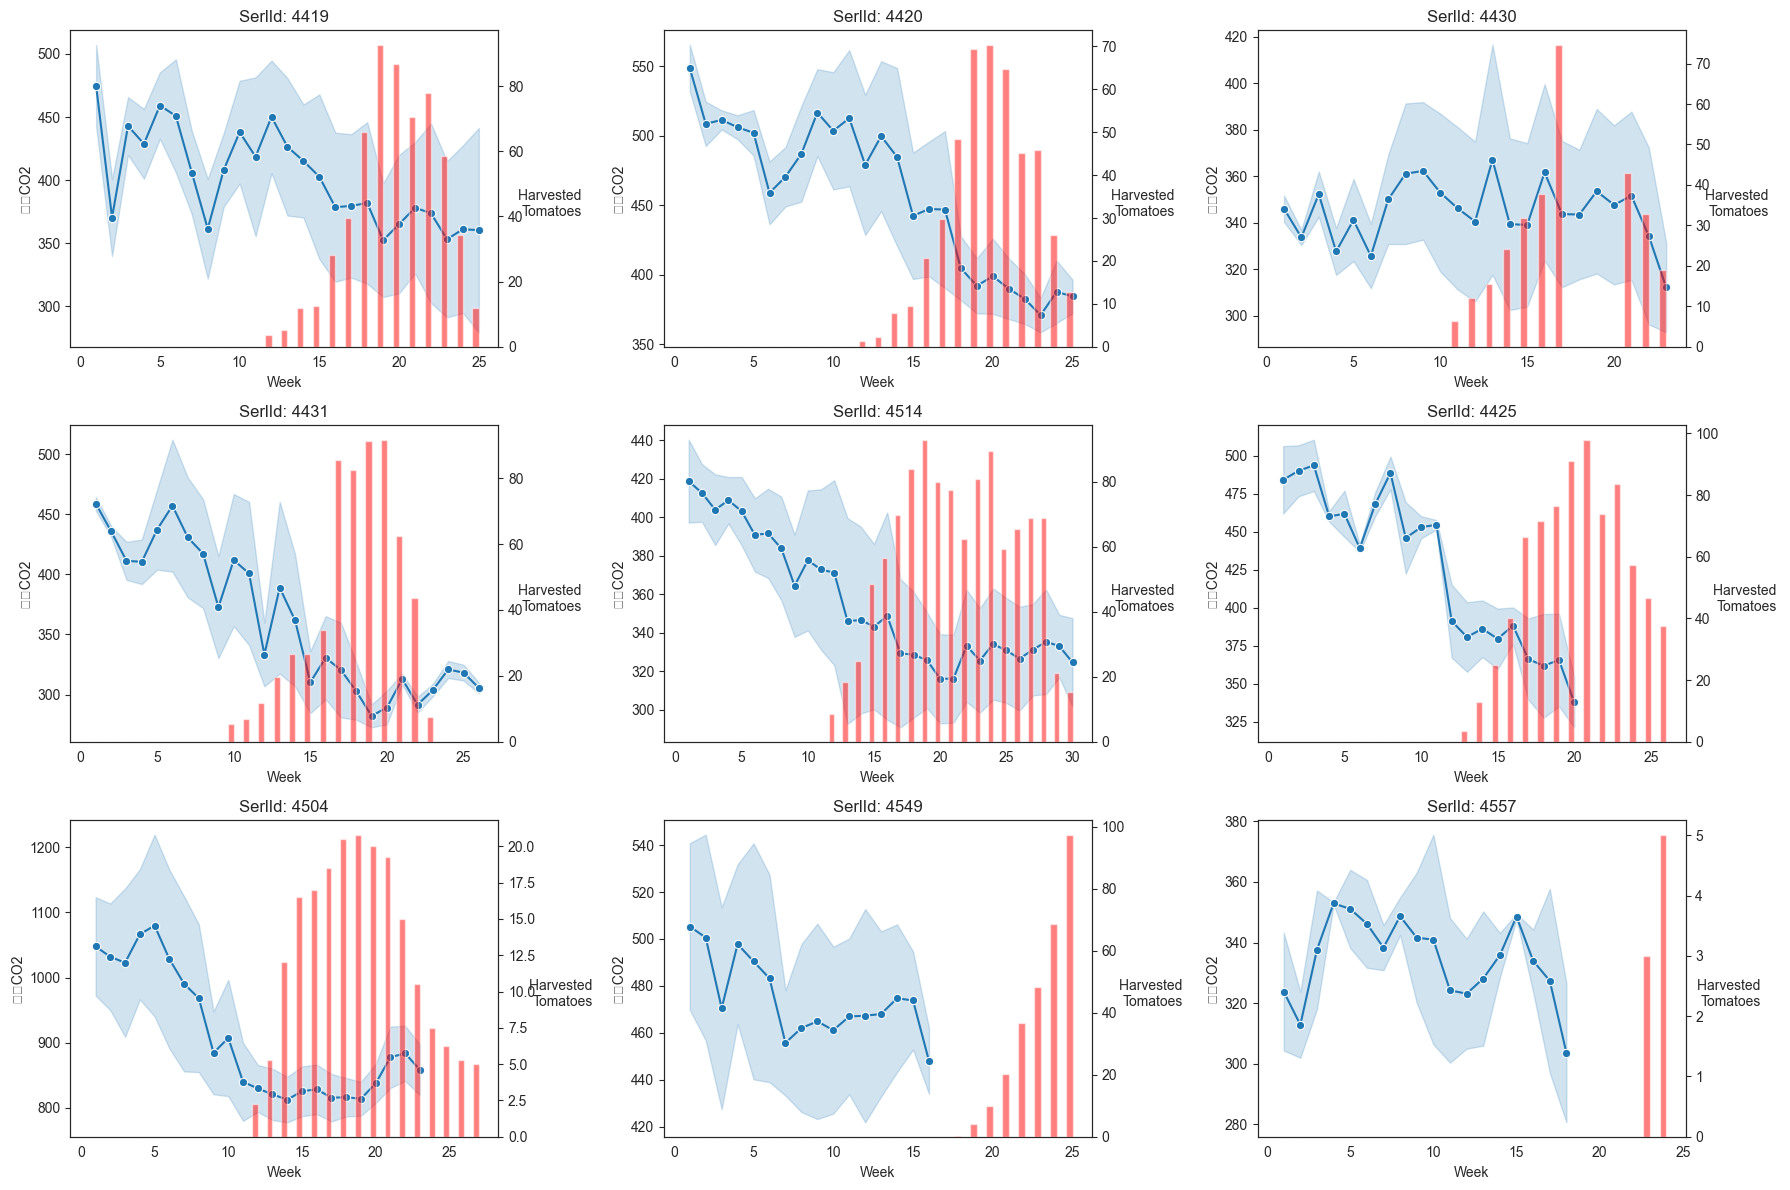

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def draw_grid_graph_harvest_and_circumstance(serl_ids, fruit_feature, circum_feature):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3x3 그리드 생성
    axes = axes.flatten()  # axes 배열을 1차원 배열로 변환

    for i, serl_id in enumerate(serl_ids):
        try:
            tomato_growth_info_pivoted = get_tomato_growth_info(raw_tomato, serl_id)
            tomato_growth_info_pivoted.reset_index(inplace=True)
            tomato_growth_info_pivoted = tomato_growth_info_pivoted[['Week', fruit_feature]]

            circumstance_trend = get_mean_by_week(raw_tomato, serl_id, circum_feature)
            if circumstance_trend[circum_feature] is np.nan:
                print(f"SerlId: {serl_id} has no data. Skipping...")
                continue
            max_week = max(circumstance_trend['Week'].max(), tomato_growth_info_pivoted['Week'].max())

            for week in range(1, max_week + 1):
                if week not in tomato_growth_info_pivoted['Week'].values:
                    missing_week_df = pd.DataFrame({'Week': [week], fruit_feature: [0]})
                    tomato_growth_info_pivoted = pd.concat([tomato_growth_info_pivoted, missing_week_df], ignore_index=True)

            tomato_growth_info_pivoted = tomato_growth_info_pivoted.sort_values(by='Week').reset_index(drop=True)

        except IndexError:
            continue
        # 현재 서브플롯에 그래프 그리기
        ax = sns.lineplot(ax=axes[i], data=circumstance_trend, x="Week", y=circum_feature, marker="o")
        ax2 = ax.twinx()
        ax2.bar(tomato_growth_info_pivoted['Week'] - 0.2, tomato_growth_info_pivoted[fruit_feature], width=0.4, alpha=0.5, color='red')
        ax2.set_ylabel('Harvested \nTomatoes', rotation=0, labelpad=20)
        ax.set_title(f'SerlId: {serl_id}')



    plt.tight_layout()
    plt.show()

# 이 함수를 호출할 때는 9개의 농장 ID 리스트를 입력으로 제공합니다.
selected_ids = list(df_tomato_id[:7]) + list(df_tomato_id[9:11])
draw_grid_graph_harvest_and_circumstance(selected_ids, '열매수(개)', '내부CO2')


In [373]:
raw_tomato[raw_tomato['SerlNo'] == df_tomato_id[10]].head(10)

,measDate,SerlNo,내부CO2,이슬점온도,(양액)공급EC,토양EC,(양액)배액EC,외부습도,내부습도,지습,...,(양액)총급액,(양액)총배액,일사량,외부온도,내부온도,지온,외부풍향,외부풍속,Starting_Date,Week
34066,2021-05-17 00:00:00,4557,347.52,NaN,NaN,NaN,NaN,NaN,93.41,72.50,...,NaN,NaN,0.00,16.00,19.23,22.14,NaN,0.0,2021-05-17,1
34067,2021-05-17 01:00:00,4557,314.91,NaN,NaN,NaN,NaN,NaN,93.44,72.14,...,NaN,NaN,0.00,16.00,17.91,22.00,NaN,0.0,2021-05-17,1
34068,2021-05-17 02:00:00,4557,362.41,NaN,NaN,NaN,NaN,NaN,94.17,71.41,...,NaN,NaN,0.00,16.00,18.00,21.00,NaN,0.0,2021-05-17,1
34069,2021-05-17 03:00:00,4557,324.77,NaN,NaN,NaN,NaN,NaN,93.76,70.91,...,NaN,NaN,0.00,19.00,17.91,21.00,NaN,0.0,2021-05-17,1
34070,2021-05-17 04:00:00,4557,343.23,NaN,NaN,NaN,NaN,NaN,94.27,81.22,...,NaN,NaN,0.00,15.00,18.00,20.32,NaN,0.0,2021-05-17,1
34071,2021-05-17 05:00:00,4557,354.14,NaN,NaN,NaN,NaN,NaN,94.44,69.82,...,NaN,NaN,1.55,15.00,19.11,20.00,NaN,0.0,2021-05-17,1
34072,2021-05-17 06:00:00,4557,366.36,NaN,NaN,NaN,NaN,NaN,94.52,69.50,...,NaN,NaN,10.05,15.00,18.00,20.00,NaN,0.0,2021-05-17,1
34073,2021-05-17 07:00:00,4557,346.09,NaN,NaN,NaN,NaN,NaN,94.18,68.82,...,NaN,NaN,23.05,15.14,20.77,20.00,NaN,0.0,2021-05-17,1
34074,2021-05-17 08:00:00,4557,345.32,NaN,NaN,NaN,NaN,NaN,94.11,68.59,...,NaN,NaN,41.82,15.00,NaN,20.00,NaN,0.0,2021-05-17,1
34075,2021-05-17 09:00:00,4557,314.23,NaN,NaN,NaN,NaN,NaN,92.15,68.14,...,NaN,NaN,107.50,15.00,18.95,20.00,NaN,0.0,2021-05-17,1


2021년, 76개의 작기에서 사용한 센서에 관한 통계

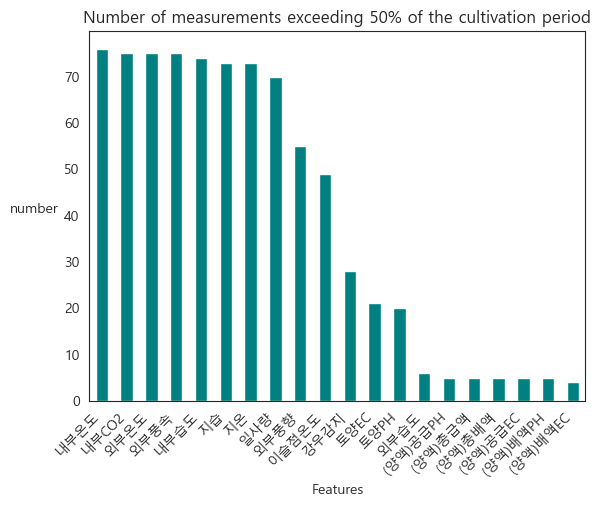

In [335]:
import pandas as pd
font_path = 'C:/Windows/Fonts/malgunsl.ttf'


# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)
# Assuming raw_tomato is your DataFrame

# Step 1 & 2: Group by 'SerlNo' and count non-NaN values for each column
non_nan_counts = raw_tomato.groupby('SerlNo').count()
#exclude measDate, week, time, Starting_Date
non_nan_counts = non_nan_counts.iloc[:,1:-2]

# Step 3: Count the total number of measurements for each 'SerlNo'
# This assumes 'measDate' has no NaN values. If it might have, use .notna().sum() instead
total_measurements = raw_tomato.groupby('SerlNo')['measDate'].count()

# Step 4: Calculate the ratio of non-NaN counts to total measurements
measurement_ratios = non_nan_counts.div(total_measurements, axis=0)

# The result is a DataFrame where each cell represents the ratio of non-NaN measurements
# for that feature for each 'SerlNo'
measurement_ratios
#convert 1 if values are over 0.5 else 0
measurement_ratios = measurement_ratios.applymap(lambda x: 1 if x > 0.5 else 0)
measurement_ratios
#summation of 1s for each column
measurement_ratios.sum()

#plotting
measurement_ratios.sum().sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Number of measurements exceeding 50% of the cultivation period')
plt.xlabel('Features',rotation=0)
plt.xticks(rotation=45, ha='right')
plt.ylabel('number', rotation=0,ha='right')
plt.show()



특정 월과 feature를 입력하면 해당 월에 재배를 시작한 작물들의 데이터프레임을 리턴받는 함수

In [344]:
import pandas as pd

def get_mean_by_week_global(raw_tomato, feature='내부CO2', start_month=1):
    # 'measDate'를 datetime으로 변환
    raw_tomato['measDate'] = pd.to_datetime(raw_tomato['measDate'])
    raw_tomato['Starting_Date'] = pd.to_datetime(raw_tomato['Starting_Date'])
    
    # 특정 달의 데이터만 필터링
    raw_tomato_filtered = raw_tomato[raw_tomato['Starting_Date'].dt.month == start_month]

    # 시간대 구분 (Day/Night)
    raw_tomato_filtered['Time'] = raw_tomato_filtered['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')

    # Week, Time별로 그룹화하여 feature 평균 계산 (SerlNo 제외)
    mean_by_week_global = raw_tomato_filtered.groupby(['Week', 'Time'])[feature].mean().reset_index()

    # feature 평균값 반올림
    mean_by_week_global[feature] = mean_by_week_global[feature].round(1)

    return raw_tomato_filtered

raw_tomato = pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
# 4월 데이터에 대한 내부CO2 평균값 계산
mean_by_week_global_april = get_mean_by_week_global(raw_tomato, feature='내부CO2', start_month=8)
mean_by_week_global_april


C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\6217150.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_tomato_filtered['Time'] = raw_tomato_filtered['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')


,measDate,SerlNo,내부CO2,이슬점온도,(양액)공급EC,토양EC,(양액)배액EC,외부습도,내부습도,지습,...,(양액)총배액,일사량,외부온도,내부온도,지온,외부풍향,외부풍속,Starting_Date,Week,Time
55019,2021-08-01 00:00:00,4749,358.32,26.00,NaN,0.0,NaN,NaN,99.89,4.0,...,NaN,0.0,24.02,26.68,27.00,NaN,0.0,2021-08-01,1,Night
55020,2021-08-01 01:00:00,4749,349.59,26.00,NaN,NaN,NaN,NaN,99.98,4.0,...,NaN,NaN,26.00,25.14,25.70,NaN,NaN,2021-08-01,1,Night
55021,2021-08-01 02:00:00,4749,365.91,24.51,NaN,0.0,NaN,NaN,99.95,4.0,...,NaN,NaN,25.45,26.00,26.00,NaN,NaN,2021-08-01,1,Night
55022,2021-08-01 03:00:00,4749,382.50,26.00,NaN,NaN,NaN,NaN,99.79,4.0,...,NaN,0.0,23.22,24.57,24.91,NaN,NaN,2021-08-01,1,Night
55023,2021-08-01 04:00:00,4749,364.98,24.70,NaN,NaN,NaN,NaN,99.83,4.0,...,NaN,NaN,25.00,26.00,24.45,NaN,NaN,2021-08-01,1,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115006,2022-06-20 19:00:00,4951,229.00,22.00,NaN,NaN,NaN,NaN,86.00,87.0,...,NaN,0.0,26.00,28.33,32.00,270.0,0.0,2021-08-30,43,Night
115007,2022-06-20 20:00:00,4951,234.00,22.00,NaN,NaN,NaN,NaN,89.00,86.0,...,NaN,0.0,25.00,27.33,31.00,90.0,0.0,2021-08-30,43,Night
115008,2022-06-20 21:00:00,4951,262.00,23.00,NaN,NaN,NaN,NaN,93.67,85.0,...,NaN,0.0,22.00,26.67,30.00,90.0,0.0,2021-08-30,43,Night
115009,2022-06-20 22:00:00,4951,292.00,23.00,NaN,NaN,NaN,NaN,94.67,84.0,...,NaN,0.0,22.00,25.67,29.00,270.0,0.0,2021-08-30,43,Night


위 함수를 시각화 한것.

C:\Users\mirun\AppData\Local\Temp\ipykernel_17880\6217150.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_tomato_filtered['Time'] = raw_tomato_filtered['measDate'].dt.hour.apply(lambda x: 'Day' if 6 <= x < 18 else 'Night')
C:\Users\mirun\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mirun\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mirun\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: Use

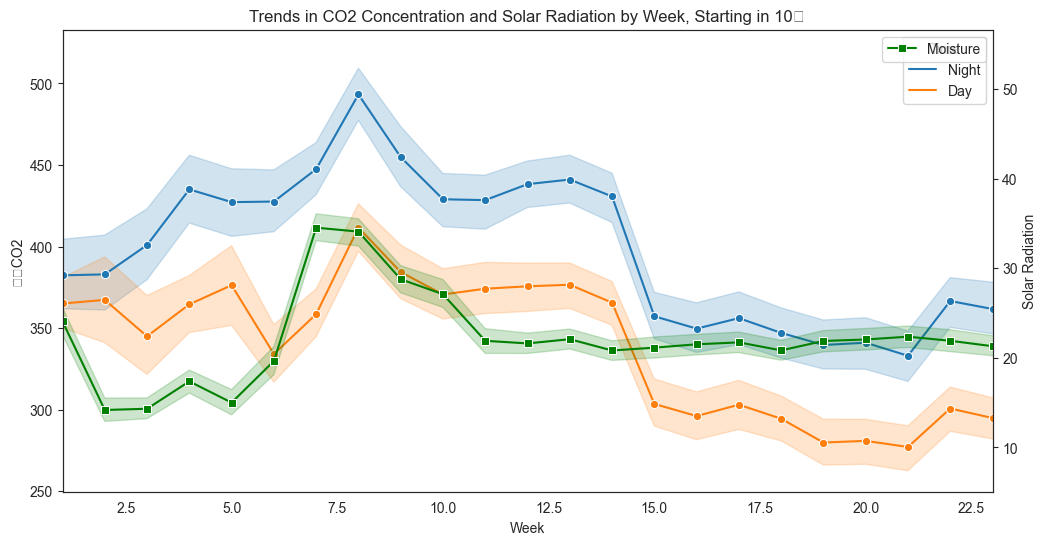

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_co2_concentration_by_week(data, start_month=10):
    sns.set_style('white')  # Seaborn 스타일 설정
    plt.figure(figsize=(12, 6))  # 그래프 사이즈 설정
    
    # 주차별 CO2 농도 변화 시각화
    sns.lineplot(data=data, x="Week", y="내부CO2", hue="Time", marker="o")
    ax2 = plt.twinx()  # y축을 공유하지 않는 새로운 축 생성
    sns.lineplot(data=data, x="Week", y="지습", ax=ax2, color="g", marker="s", label='Moisture')
    
    
    # 축 및 제목 설정
    plt.title(f"Trends in CO2 Concentration and Solar Radiation by Week, Starting in {start_month}월")
    ax.figure.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.xlim(1, 23)  # X축 범위 설정
    ax.set_ylabel('CO2 Concentration')
    ax2.set_ylabel('Solar Radiation')

    plt.show()

mean_by_week_global = get_mean_by_week_global(raw_tomato, feature=['내부CO2','지습'], start_month=10)
plot_co2_concentration_by_week(mean_by_week_global,start_month=10)



재배 시작 시기 통계

Text(0, 0.5, 'Number of\nFarms')

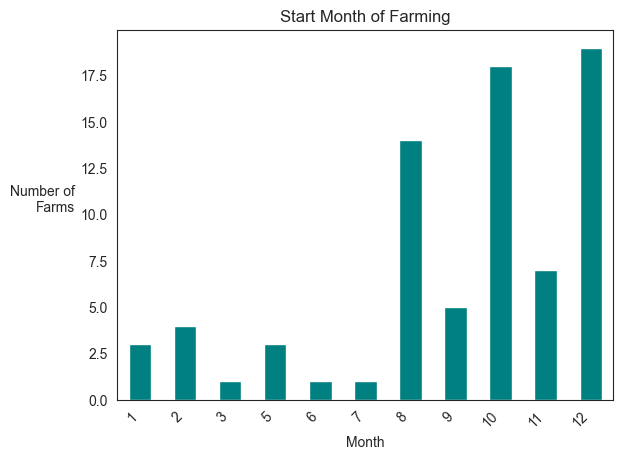

In [252]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
raw_tomato=pd.read_csv('2021_tomato_pivoted.csv', encoding='cp949')
start_dates = raw_tomato.groupby('SerlNo')['Starting_Date'].min().reset_index()
start_dates['Starting_Date'] = pd.to_datetime(start_dates['Starting_Date'])

start_dates['Start_Month'] = start_dates['Starting_Date'].dt.month
start_dates['Start_Month'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Start Month of Farming')
plt.xlabel('Month', rotation=0)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of\nFarms', rotation=0, ha='right')

# # y축을 정수로 설정
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# plt.show()


재배 기간 통계

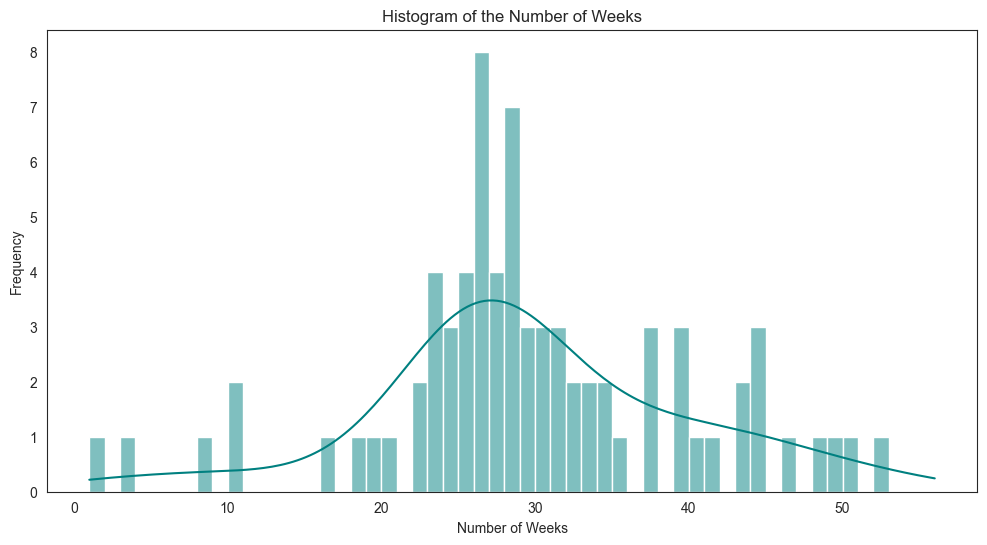

,SerlNo,Week
65,4957,56
15,4731,52
38,4827,50
32,4796,49
11,4685,48
...,...,...
10,4577,10
20,4749,10
64,4955,8
36,4819,3


In [160]:

max_week_per_serno = raw_tomato.groupby('SerlNo')['Week'].max().reset_index()

# calculate an average of the maximum week per serno
max_week_per_serno['Week'].mean()
#draw a histogram of the number of weeks
plt.figure(figsize=(12, 6))
sns.histplot(max_week_per_serno['Week'], bins=range(1, 56), kde=True, color='teal')
plt.title('Histogram of the Number of Weeks')
plt.xlabel('Number of Weeks')
plt.ylabel('Frequency')
plt.show()

#sort the number of weeks by SerlNo
max_week_per_serno.sort_values('Week', ascending=False)



2021년의 모든 생육정보를 concat하는 과정

In [255]:
import pandas as pd
import matplotlib.pyplot as plt

# 빈 DataFrame 초기화
all_farms_data = pd.DataFrame()

# 각 농장 ID별로 데이터를 가져오고 전체 데이터셋에 추가
for Serlid in df_tomato_id:
    try:
        spec = get_tomato_growth_info(raw_tomato, Serlid)
        spec_reset = spec.reset_index(level='Week')
        spec_reset['SerlNo'] = Serlid  # 농장 ID를 데이터에 추가
        all_farms_data = pd.concat([all_farms_data, spec_reset])
    except IndexError:
        continue
        
all_farms_data




        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
        * 응답 메세지 명세 *
            fcltyId: 시설 ID String 
            croppingSerlNo: 작기 일련번호 Integer 
            itemCode: 품목코드 String (별첨 1. 품목코드 참고)
            sampleNo: 표본 번호 Integer 
            examinMasterSn: 생육조사마스터 일련번호 Integer 
            examinSn: 조사 일련번호 Integer 
            examinDe: 조사 일자 String (형식 : yyyymmdd)
            examinIemCode: 조사 항목 코드 String 
            examinIemNm: 조사 항목명 String 
            examinIemValue: 조사 항목 측정값 Double 
            examinIemUnit: 조사 항목 단위 String 
        

        * Response *
            - statusCode    : 00
            - statusMessage : NORMAL_CODE
            - statusDesc    : 정상
        
4419 농장 데이터 추가 완료

        상세 기능 번호  : 4
        상세 기능 설명  : 스마트팜 보급 농가 사용자의 작기별 생육 정보 조회
        
        * 요청 메세지 명세 *   
            croppingSerlNo: 작기 일련번호 Integer 
            
   

examine_feature,Week,개화군(점),생장길이(mm),열매수(개),엽수(개),엽장(mm),엽폭(mm),줄기직경(mm),착과군(점),최종화방차수(차),화방높이(mm),SerlNo,마디수(마디),암꽃수(개),초장(mm),관부직경(mm),엽병장(mm),착과수(개),화방 꽃수(소화수)(개)
examinDe,,,,,,,,,,,,,,,,,,,
2021-01-20,2,0.00,0.0,0.00,6.50,89.25,54.00,2.0850,0.00,0.00,0.0,4419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-27,3,0.00,67.5,0.00,8.50,107.50,70.00,2.5850,0.00,0.00,0.0,4419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-03,4,0.00,37.5,0.00,7.25,168.75,116.25,2.7800,0.00,0.00,0.0,4419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-09,5,0.00,45.0,0.00,9.75,192.50,114.25,3.3625,0.00,0.00,0.0,4419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-17,6,0.00,82.5,0.00,15.75,160.00,105.00,4.7850,0.00,0.00,0.0,4419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,51,8.25,0.0,45.75,12.75,439.00,259.00,8.3875,8.25,9.25,0.0,4918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-31,52,8.25,0.0,31.75,12.75,439.00,259.00,8.3875,8.25,9.25,0.0,4918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-07,53,8.25,0.0,13.00,12.75,439.00,259.00,8.3875,8.25,9.25,0.0,4918,NaN,NaN,NaN,NaN,NaN,NaN,NaN


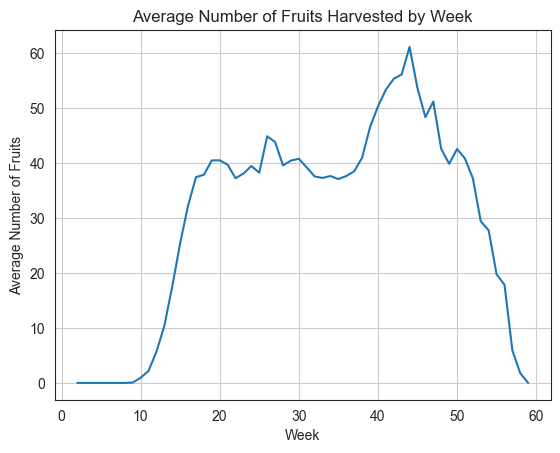

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns

# 주별로 '열매수(개)'의 평균을 계산
weekly_fruit_avg = all_farms_data.groupby('Week')['열매수(개)'].mean().reset_index()
weekly_fruit_avg
#결과 시각화
sns.lineplot(data=weekly_fruit_avg, x='Week', y='열매수(개)')
plt.xlabel('Week')
plt.ylabel('Average Number of Fruits')
plt.title('Average Number of Fruits Harvested by Week')
plt.grid(True)
plt.show()
